## 載入雲端硬碟

In [1]:
# ============ Colab Environment (Commented out) ============
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/your folder/ # 請改成自己的路徑

# ============ Local Environment with Dual V100 GPUs ============
import os
os.chdir('/home/twccjq88/2025EAI_Project/EAI_Lab6')
print(f"Working directory: {os.getcwd()}")

Working directory: /home/twccjq88/2025EAI_Project/EAI_Lab6


## 安裝依賴項

In [ ]:
# !pip install torch torchvision timm==0.4.12 einops


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [timm]1/2 [timm]


## 下載checkpoint

In [3]:
!pip install gdown

In [4]:
# Download checkpoint if not exists
import os
if not os.path.exists('./evit_0.7.pth'):
    !gdown https://drive.google.com/uc?id=1FfvdEBss9f8gexjqEY8vOSUQe_8qwYuL -O evit_0.7.pth
    print("Checkpoint downloaded successfully!")
else:
    print("Checkpoint already exists, skipping download.")

Downloading...
From (original): https://drive.google.com/uc?id=1FfvdEBss9f8gexjqEY8vOSUQe_8qwYuL
From (redirected): https://drive.google.com/uc?id=1FfvdEBss9f8gexjqEY8vOSUQe_8qwYuL&confirm=t&uuid=0b705c04-ebd4-46da-933d-bcfad4bac872
To: /home/twccjq88/2025EAI_Project/EAI_Lab6/evit_0.7.pth
100%|████████████████████████████████████████| 353M/353M [00:07<00:00, 46.8MB/s]
Checkpoint downloaded successfully!


## 基本配置

In [5]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn


seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True

# Check available GPUs (Dual V100 setup)
n_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {n_gpus}")
for i in range(n_gpus):
    print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

# Use first GPU for this evaluation task (single model inference doesn't benefit much from multi-GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Number of available GPUs: 1
  GPU 0: Tesla V100-SXM2-32GB
Using device: cuda:0


## MLP


In [6]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(0) # 等於沒有dropout，因為 eval 時不會啟用 dropout，本lab只會做 eval，因此為求方便直接這樣設置

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

## Patch Embedding


In [7]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.Identity()
    def forward(self, x):
        x = self.proj(x)             # (B, C, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)    # (B, N, C)
        return x

##　Attention

In [9]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, keep_rate=1.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(0)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(0)
        self.keep_rate = keep_rate

    def forward(self, x):
        B, N, C = x.shape # N 有包含 CLS Token，若有 fused token 也會包括在內
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn) # [B, H, N, N]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        left_tokens = N - 1
        if self.keep_rate < 1 :
            ########################################
            # 請實作 EViT 的 token pruning  #
            ########################################
            # 1. 根據 keep_rate 設定要保留的 token 數
            # N-1 because we exclude CLS token; use ceil to ensure at least some tokens are kept
            left_tokens = math.ceil((N - 1) * self.keep_rate)
            
            # 2. image token (包括 fused token) 的 cls attention 分數
            # attn shape: [B, H, N, N], we need CLS (index 0) attending to image tokens (index 1:)
            # Average across all heads to get importance score for each image token
            cls_attn = attn[:, :, 0, 1:].mean(dim=1)  # [B, N-1]

            # 3. 按照分數取出 left_tokens 個分數高的 token 的 idx，並按照分數排序
            # topk returns (values, indices), we need sorted=True to maintain order by importance
            _, idx = torch.topk(cls_attn, left_tokens, dim=1, sorted=True)  # [B, left_tokens]

            # 4. 得到 index
            # Expand idx to [B, left_tokens, C] for gathering tokens from feature tensor
            index = idx.unsqueeze(-1).expand(-1, -1, C)  # [B, left_tokens, C]
            ########################################

            return x, index, idx, cls_attn, left_tokens
            # idx 是要保留的 token 的索引 [B, left_tokens]
            # index 是 idx 擴展成多 channel 的版本 [B, left_tokens, C]
            # cls_atten 是 cls token 對其他每個 token 的注意力
            # left_tokens 是保留的 token 數量


        return  x, None, None, None, left_tokens

## Transformer Block

In [10]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., keep_rate=1.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, num_heads, keep_rate)
        self.drop_path = nn.Identity()
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.mlp = Mlp(dim, int(dim * mlp_ratio))
        self.keep_rate = keep_rate

    def forward(self, x, get_idx=False):
        B, N, C = x.shape
        x_norm = self.norm1(x)
        tmp, index, idx, cls_attn, left_tokens =self.attn(x_norm)


        x = x + self.drop_path(tmp)

        if index is not None: # 代表這層 Transformer 需要 pruning
            ########################################
            # 請實作 EViT 的 token pruning  #
            ########################################
            # 1. 先得到要保留的 tokens
            # x[:, 0:1, :] is CLS token, x[:, 1:, :] are image tokens
            cls_token = x[:, 0:1, :]  # [B, 1, C]
            image_tokens = x[:, 1:, :]  # [B, N-1, C]
            kept_tokens = torch.gather(image_tokens, dim=1, index=index)  # [B, left_tokens, C]

            # 2. 再得到要融合的其他 tokens
            # Get complement indices (tokens not in idx)
            compl_idx = complement_idx(idx, N - 1)  # [B, N-1-left_tokens]
            compl_index = compl_idx.unsqueeze(-1).expand(-1, -1, C)  # [B, N-1-left_tokens, C]
            fuse_tokens = torch.gather(image_tokens, dim=1, index=compl_index)  # [B, N-1-left_tokens, C]

            # 3. 用 cls token 對每個要融合的 image tokens 的注意力作為權重，將所有要融合的 token 加權成一個 fused token。
            # Get attention weights for tokens to be fused
            fuse_attn = torch.gather(cls_attn, dim=1, index=compl_idx)  # [B, N-1-left_tokens]
            # Normalize weights using softmax to sum to 1
            fuse_weights = F.softmax(fuse_attn, dim=1).unsqueeze(-1)  # [B, N-1-left_tokens, 1]
            # Weighted sum of fused tokens
            fused_token = (fuse_tokens * fuse_weights).sum(dim=1, keepdim=True)  # [B, 1, C]

            # 4. 把 CLS Token, 要保留的 image tokens, fused token 三個 concat 在一起 # [B, left_tokens+2, C]
            x = torch.cat([cls_token, kept_tokens, fused_token], dim=1)  # [B, left_tokens+2, C]
            ########################################

        x = x + self.drop_path(self.mlp(self.norm2(x)))
        n_tokens = x.shape[1] - 1
        if get_idx and index is not None:
            return x, n_tokens, idx
        return x, n_tokens, None

####################################################
#  提供一個取補集的 function 給同學可以使用  #
####################################################
def complement_idx(idx, dim):
    """
    Compute the complement: set(range(dim)) - set(idx).
    Args:
        idx: input index [B, left_tokens]
        dim: the max number of index for complement
    """
    a = torch.arange(dim, device=idx.device)
    ndim = idx.ndim
    dims = idx.shape
    n_idx = dims[-1]
    dims = dims[:-1] + (-1, )
    for i in range(1, ndim):
        a = a.unsqueeze(0)
    a = a.expand(*dims)
    masked = torch.scatter(a, -1, idx, 0)
    compl, _ = torch.sort(masked, dim=-1, descending=False)
    compl = compl.permute(-1, *tuple(range(ndim - 1)))
    compl = compl[n_idx:].permute(*(tuple(range(1, ndim)) + (0,)))
    return compl

## 主體模型 EViT

In [11]:
class EViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 num_classes=1000, embed_dim=384, depth=12,
                 num_heads=6, mlp_ratio=4.0, keep_rate=(1, 1, 1, 0.7) + (1, 1, 0.7) + (1, 1, 0.7) + (1, 1)):
        super().__init__()
        self.keep_rate = keep_rate
        self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        self.pos_drop = nn.Dropout(0)
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, keep_rate=keep_rate[i])
            for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.pre_logits = nn.Identity()
        self.head = nn.Linear(embed_dim, num_classes)

    @property
    def name(self):
        return "EViT"

    def forward_features(self, x, get_idx=False):
        _, _, h, w = x.shape

        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        pos_embed = self.pos_embed

        x = self.pos_drop(x + pos_embed)

        left_tokens = []
        idxs = []
        for i, blk in enumerate(self.blocks):
            x, left_token, idx = blk(x, get_idx)
            left_tokens.append(left_token)
            if idx is not None:
                idxs.append(idx)
        x = self.norm(x)
        return self.pre_logits(x[:, 0]), left_tokens, idxs


    def forward(self, x, get_idx=False):
        x, _, idxs = self.forward_features(x, get_idx)
        x = self.head(x)
        if get_idx:
            return x, idxs
        return x

## 載入 EViT

In [12]:
model_path = './evit_0.7.pth'

model = EViT(keep_rate=(1, 1, 1, 0.7) + (1, 1, 0.7) + (1, 1, 0.7) + (1, 1))
checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)

model.load_state_dict(checkpoint['model'])


<All keys matched successfully>

## Dataloader

In [13]:
from torchvision import transforms, datasets
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import DataLoader

transform_eval = transforms.Compose([
    transforms.Resize(int((256 / 224) * 224), interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

dataset_val = datasets.ImageFolder(root='./imagenet/val', transform=transform_eval)
# 新的 class_to_idx，把資料夾名稱轉成 int
new_class_to_idx = {cls_name: int(cls_name) for cls_name in dataset_val.classes}
# 舊索引所對應的資料夾名稱
idx_to_class = {v: k for k, v in dataset_val.class_to_idx.items()}
# 更新 samples 裡的 label
dataset_val.samples = [
    (path, new_class_to_idx[idx_to_class[old_label]])
    for path, old_label in dataset_val.samples
]
# 更新 class_to_idx
dataset_val.class_to_idx = new_class_to_idx

val_loader = DataLoader(dataset_val, batch_size=1, shuffle=False)

## Visualize Function

In [14]:
from timm.utils import accuracy
import matplotlib.pyplot as plt
from einops import rearrange

def visualize_mask(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()

    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=device).reshape(3, 1, 1)
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=device).reshape(3, 1, 1)

    # switch to evaluation mode
    model.eval()
    total_loss = 0.0
    total_acc1 = 0.0
    total_acc5 = 0.0
    total_samples = 0

    ii = 0
    for i, (images, target) in enumerate(data_loader):
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        B = images.size(0)

        with torch.amp.autocast('cuda'):
            output, idx = model(images, get_idx=True)
            print('Predict: ',int(output.argmax(dim=1)))
            print('Answer: ',int(target))
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        total_loss += loss.item() * B
        total_acc1 += acc1.item() * B
        total_acc5 += acc5.item() * B
        total_samples += B

        # denormalize
        images = images * std + mean

        idxs = get_real_idx(idx, fuse_token=True)

        fig, axes = plt.subplots(1, len(idxs) + 1, figsize=(4 * (len(idxs) + 1), 4))

        # 原圖
        axes[0].imshow(images[0].detach().cpu().permute(1, 2, 0).numpy().clip(0, 1))
        axes[0].set_title("Original")
        axes[0].axis("off")

        # masked 圖
        for jj, idx in enumerate(idxs):
            masked_img = mask(images, patch_size=16, idx=idx)
            img_np = masked_img[0].detach().cpu().permute(1, 2, 0).numpy().clip(0, 1)
            axes[jj + 1].imshow(img_np)
            axes[jj + 1].set_title(f"Layer {jj*3+4}")
            axes[jj + 1].axis("off")

        plt.show()

        ii += 1

        print(f"[{i+1}/{len(data_loader)}] "
                  f"Loss: {total_loss / total_samples:.4f}, "
                  f"Acc@1: {total_acc1 / total_samples:.2f}%, "
                  f"Acc@5: {total_acc5 / total_samples:.2f}%")

    avg_loss = total_loss / total_samples
    avg_acc1 = total_acc1 / total_samples
    avg_acc5 = total_acc5 / total_samples
    print(f"\n* Final: Acc@1 {avg_acc1:.2f}%  Acc@5 {avg_acc5:.2f}%  Loss {avg_loss:.4f}")

    return {"loss": avg_loss, "acc1": avg_acc1, "acc5": avg_acc5}

# 在多層 Transformer 裡，追蹤每一層被 prune 完保留的 token idx 對應到原始影像的實際位置。
# 例如像第二層所保留的 token idx 是相對於第一層的結果，而不是相對於最一開始的輸入，因此要轉換回對應於最一開始的輸入 token
def get_real_idx(idxs, fuse_token):
    for i in range(1, len(idxs)):
        ########################################
        #       請實作         #
        ########################################
        # idxs[i] values are indices relative to the output of layer i-1
        # idxs[i-1] contains the absolute indices (relative to original image patches)
        # We need to map idxs[i] -> absolute indices using idxs[i-1]
        
        prev_size = idxs[i-1].size(1)  # Number of kept tokens from previous layer
        
        if fuse_token:
            # If fuse_token is True, layer i-1 output has: kept_tokens + 1 fused_token
            # idxs[i] may point to fused token (index = prev_size), which has no original position
            # Clamp to valid range to handle this edge case
            idx_clamped = torch.clamp(idxs[i], max=prev_size - 1)
        else:
            idx_clamped = idxs[i]
        
        # Map relative indices to absolute indices by gathering from previous layer's indices
        idxs[i] = torch.gather(idxs[i-1], dim=1, index=idx_clamped)
        ########################################

    return idxs
    # idxs 的每個元素都是有 pruning 的層要保留的 tokens 的索引(idx, [B, left_tokens])
    # idxs[i] 是第 i 個有 pruning 的層的要保留的 tokens 的索引 [B, left_tokens]


# 保留 idx 對應的 patch，其他位置全部填零（遮掉）
def mask(x, idx, patch_size):
    """
    Args:
        x: input image, shape: [B, 3, H, W]
        idx: indices of masks, shape: [B, T]（T = 要保留的 token 數量）, value in range [0, h*w)
    Return:
        out_img: masked image with only patches from idx postions
    """
    h = x.size(2) // patch_size
    x = rearrange(x, 'b c (h p) (w q) -> b (c p q) (h w)', p=patch_size, q=patch_size)
    output = torch.zeros_like(x)
    idx1 = idx.unsqueeze(1).expand(-1, x.size(1), -1)
    extracted = torch.gather(x, dim=2, index=idx1)  # [b, c p q, T]
    scattered = torch.scatter(output, dim=2, index=idx1, src=extracted)
    out_img = rearrange(scattered, 'b (c p q) (h w) -> b c (h p) (w q)', p=patch_size, q=patch_size, h=h)
    return out_img

### Visualization

Predict:  1
Answer:  1


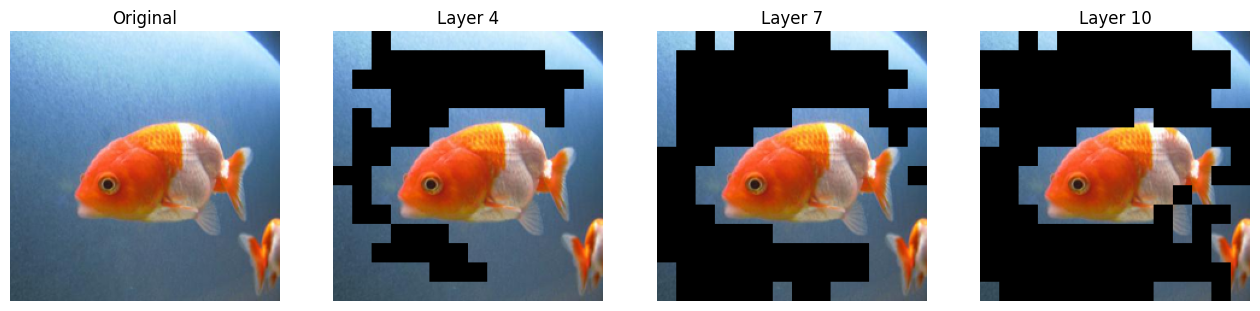

[1/5] Loss: 0.1322, Acc@1: 100.00%, Acc@5: 100.00%
Predict:  7
Answer:  7


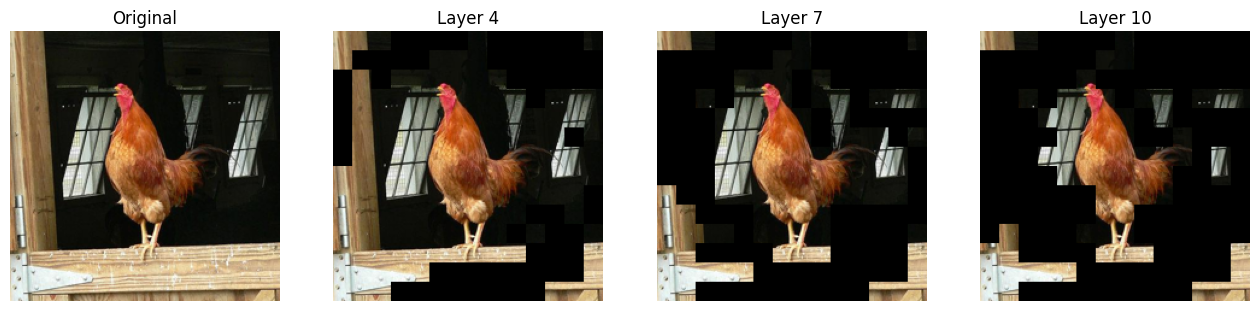

[2/5] Loss: 0.4120, Acc@1: 100.00%, Acc@5: 100.00%
Predict:  10
Answer:  10


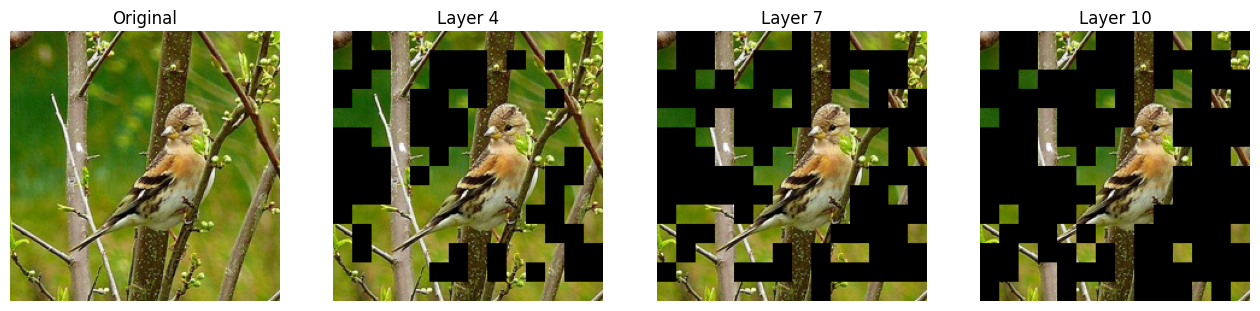

[3/5] Loss: 0.3464, Acc@1: 100.00%, Acc@5: 100.00%
Predict:  29
Answer:  29


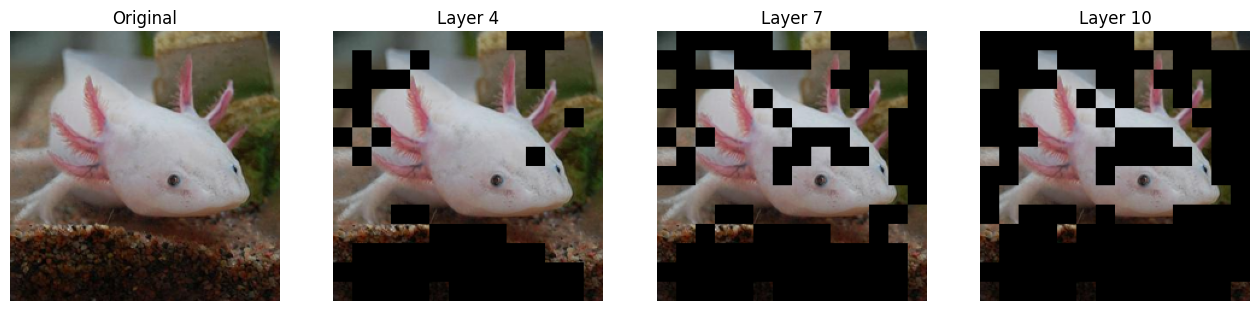

[4/5] Loss: 0.2989, Acc@1: 100.00%, Acc@5: 100.00%
Predict:  84
Answer:  84


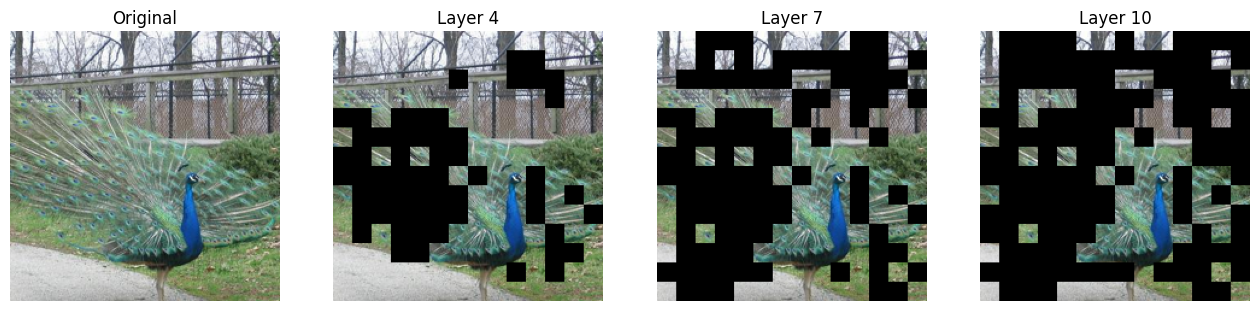

[5/5] Loss: 0.2790, Acc@1: 100.00%, Acc@5: 100.00%

* Final: Acc@1 100.00%  Acc@5 100.00%  Loss 0.2790


{'loss': 0.27900390625, 'acc1': 100.0, 'acc5': 100.0}

In [15]:
model = model.to(device)
visualize_mask(val_loader, model, device)